# Begin Milestone01

## Summary

My goal with this large dataset was to select a subset of features that would best be able to model the relationship between all the features and their labels (-1 or 1). After attempting to find the best feature selection, it looks at first like Embedded method features have the highest accuracy with this senario. However, it's a bit of a red flag that most of the model methods have the highest accuracy with the Embedded features. The Embedded features may be overfitting the dataset. 

Instead, I've decided to use the Wrapper method features because they scored the 2nd highest in accuracy mean accross all feature selection methods and model types.

What I did:
- loaded the two datasets
- removed outliers
- changed date column to be datetime
- merged the dataframes
- imputed missing values (NaNs) with the most frequent value
- created a correlation matrix and visualized it with a heatmap
- handled the class imbalance problem using SMOTE
- used Filter, Wrapper, and Embedded methods to select a subset of features for my model
- tried out 6 different model types with all three filter selections and plotted accuracy

In [0]:
#importing necessary packages
import pandas as pd
import numpy as np
from numpy import matlib
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
import datetime as dt
import scipy.stats as ss
import scipy
import seaborn as sns
import statsmodels.stats.power as smsp
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import graphviz
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

#matplotlib formatting that I like
%matplotlib inline

In [0]:
#loading and reading the datasets
filename_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
filename_labels = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

df1 = pd.read_csv(filename_data, sep = ' ', header = None)
df2 = pd.read_csv(filename_labels, sep = ' ', header = None)

In [0]:
#finding and removing any outliers (points above the upper and below the low percentile)
#only for columns 0 - 589 columns 590 and 591 are classifiers and datetime
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    good_points = pd.DataFrame()
    for y in range(0,589):
        not_outlier = df[y][(df[y] > quant_df.loc[low, y]) & (df[y] < quant_df.loc[high, y])]
        if len(not_outlier) > 1299:
            good_points[y] = not_outlier
        else:
            good_points[y] = df[y]
    return good_points

df1_NoOutliers = remove_outlier(df1)

In [4]:
#need to change the collection dates (column 590) to datetime format!
df2[1] = pd.to_datetime(df2[1], format='%d/%m/%Y %H:%M:%S')
print("Min Date=%s, Max Date=%s"%(min(df2[1]).strftime("%Y-%m-%d"), \
                                          max(df2[1]).strftime("%Y-%m-%d")))

Min Date=2008-07-19, Max Date=2008-10-17


In [5]:
#merging the two datasets
df1_NoOutliers[590], df1_NoOutliers[591] = df2[1], df2[0]
diaper_df = df1_NoOutliers
diaper_df = diaper_df.sort_values(by = 590) #sorted by datetime

diaper_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,590,591
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,NaN,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,NaN,NaN,NaN,64.2333,2.0222,0.1632,3.5191,NaN,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,2008-07-19 11:55:00,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,NaN,50.6596,64.2828,49.3404,NaN,NaN,118.1188,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,NaN,4.4447,0.0096,0.0201,0.0060,2008-07-19 12:32:00,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,NaN,NaN,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,NaN,118.6128,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,NaN,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,NaN,NaN,NaN,2008-07-19 13:17:00,1
3,2988.72,2479.90,2199.0333,NaN,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,NaN,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,NaN,86.6867,NaN,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,NaN,NaN,NaN,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,NaN,2.0544,0.0202,0.0149,0.0044,2008-07-19 14:43:00,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,NaN,NaN,NaN,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,NaN,NaN,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0202,0.0149,0.0044,2008-07-19 15:22:00,-1


In [6]:
#imputing missing values with the most frequent value in its column
for i in diaper_df.columns:
    mean_value=diaper_df[i].mode()[0]
    diaper_df[i]=diaper_df[i].fillna(mean_value)

#checking to make sure no more NaNs exist in diaper_df
print("NaN count in diaper_df: ", diaper_df.isnull().sum().sum())

NaN count in diaper_df:  0


In [0]:
#attempting to visualize all the data at once

#creating a correlation matrix 
corr = diaper_df.corr()
#plotting the correlation matrix as a heatmap

##WARNING it may take a couple minutes since I'm trying to plot every column

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


### From the correlation heat map above, I can already see what features may be the most correlated to the label column (last col 591) by it's correlation number. I can also see where the all NaN correlation columns are (columns that are constant) and where other features might be correlated. 

In [0]:
#creating my model variables
X = diaper_df.drop([590,591], axis = 1)
Y = diaper_df[591]

In [0]:
#creating training/testing variables based on the X and Y dataframes, 
#test size is 1/4 the size of our input data
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.25)

In [9]:
#the class imbalance problem:
diaper_df[591].value_counts()

-1    1319
 1      84
Name: 591, dtype: int64

In [10]:
#handling the class imbalance problem with SMOTE
sm = SMOTE(random_state=42)
X_resam, Y_resam = sm.fit_sample(x_train, y_train)
print('Resampled diaper_df shape {}'.format(Counter(Y_resam)))

Resampled diaper_df shape Counter({-1: 986, 1: 986})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Feature Selection and Model Tryout

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [12]:
#using mutual_score_info to determine correlation for each continuous(numerical) variable
from sklearn.metrics import mutual_info_score

CORR = []

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

for i in X.columns:
    # Calculation Correlation
    X_ = X[i]

    #correlation
    corr = np.corrcoef(X[i], Y)[0,1]

    #mutual information
    mi = calc_MI(X[i], Y, 20)
    
    CORR.append([i, corr, mi])

CORR = pd.DataFrame(CORR, columns = ['Variable', 'Correlation', 'Mutual Information'])
CORR.sort_values(by=['Mutual Information'], ascending=False)

#creating my Filter_Features array, which contains each feature I've selected from the filter method above
Filter_Features = []
Filter_Features.extend(np.array(CORR.sort_values(by=['Mutual Information'], ascending=False)['Variable'][1:10]))

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: 

In [0]:
Filter_Features

[247, 153, 331, 477, 288, 65, 103, 571, 540]

In [0]:
Filter_Results = []
    
#creating my model variables based on the IntDet_model dataframe, and the Class series
#test size is 1/4 the size of our input data, and we have 42 variabels total
X_train, X_validation, Y_train, Y_validation = train_test_split(X_resam[Filter_Features], Y_resam, 
                                                test_size=0.25)

# using the models below to evaluate my selected features
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
    
for name, model in models:
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    Filter_Results.append([name, cv_results.mean(), cv_results.std()])    

Filter_Results = pd.DataFrame(Filter_Results)
Filter_Results.columns = ['Model', 'Accuracy Mean', 'Accuracy SD']
Filter_Results

,Model,Accuracy Mean,Accuracy SD
0,LR,0.612162,0.041122
1,LDA,0.669595,0.038868
2,KNN,0.681757,0.047147
3,CART,0.847973,0.029179
4,NB,0.704730,0.043690
5,SVM,0.631757,0.040681


In [0]:
#Backward Model Selection
# Recursive Feature Elimination
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LinearRegression

LinReg = LinearRegression()
selector = RFE(LinReg, 10, step=1)#select 5 features. Step=1 means each step only remove 1 variable from the model
selector = selector.fit(X_resam, Y_resam)
# The mask of selected features.
# selected features are ranked 1. The 6th is the one that is removed first,
# 2nd is the one that is removed last
X_resam = pd.DataFrame(X_resam) #need to be a df for below's transformations
Wrapper_Features_df = pd.DataFrame(np.stack((X_resam.columns, selector.support_, selector.ranking_)))
Wrapper_Features_df = Wrapper_Features_df.transpose()
Wrapper_Features_df.columns = ['Variable', 'Support', 'Ranking']
Wrapper_Features_df.sort_values(by='Ranking')
Wrapper_Features_df = Wrapper_Features_df[Wrapper_Features_df['Ranking']==1]
Wrapper_Features_df #feature selection from the wrapper method!

Wrapper_Features = list(Wrapper_Features_df['Variable'])

In [20]:
Wrapper_Features

[34, 36, 92, 95, 101, 105, 244, 357, 358, 382]

In [21]:
Wrapper_Results = []
    
#creating my model variables based on the IntDet_model dataframe, and the Class series
#test size is 1/4 the size of our input data, and we have 42 variabels total
X_train, X_validation, Y_train, Y_validation = train_test_split(X_resam[Wrapper_Features], Y_resam, 
                                                test_size=0.25)

# using the models below to evaluate my selected features
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
    
for name, model in models:
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    Wrapper_Results.append([name, cv_results.mean(), cv_results.std()])    

Wrapper_Results = pd.DataFrame(Wrapper_Results)
Wrapper_Results.columns = ['Model', 'Accuracy Mean', 'Accuracy SD']
Wrapper_Results

,Model,Accuracy Mean,Accuracy SD
0,LR,0.547642,0.029922
1,LDA,0.649733,0.035666
2,KNN,0.650427,0.032957
3,CART,0.911418,0.020191
4,NB,0.586197,0.044065
5,SVM,0.531398,0.032234


In [0]:
# LASSO
from sklearn import linear_model

alpha = .01 # Increasing alpha can shrink more variable coefficients to 0
clf = linear_model.Lasso(alpha=alpha)
clf.fit(X_resam, Y_resam)

Embedded_Features_df = pd.DataFrame(np.stack((X_resam.columns, clf.coef_)))
Embedded_Features_df = Embedded_Features_df.transpose()
Embedded_Features_df.columns = ['Variable', 'Coefficients']
Embedded_Features_df.reindex(Embedded_Features_df['Coefficients'].abs().sort_values(ascending=False).index)
Embedded_Features_df = Embedded_Features_df[Embedded_Features_df['Coefficients']!=0]
Embedded_Features_df #feature selection from the Embedded Method!

Embedded_Features = list(Embedded_Features_df['Variable'])

In [0]:
Embedded_Features

[0.0,
 1.0,
 2.0,
 3.0,
 6.0,
 12.0,
 14.0,
 15.0,
 18.0,
 21.0,
 22.0,
 23.0,
 24.0,
 27.0,
 28.0,
 32.0,
 33.0,
 39.0,
 40.0,
 43.0,
 45.0,
 46.0,
 48.0,
 50.0,
 51.0,
 55.0,
 59.0,
 60.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 68.0,
 70.0,
 71.0,
 72.0,
 73.0,
 88.0,
 90.0,
 115.0,
 117.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139.0,
 142.0,
 148.0,
 151.0,
 154.0,
 158.0,
 159.0,
 160.0,
 161.0,
 162.0,
 177.0,
 180.0,
 182.0,
 183.0,
 185.0,
 187.0,
 188.0,
 196.0,
 197.0,
 199.0,
 200.0,
 201.0,
 202.0,
 203.0,
 205.0,
 208.0,
 223.0,
 225.0,
 246.0,
 250.0,
 268.0,
 270.0,
 271.0,
 272.0,
 273.0,
 274.0,
 286.0,
 289.0,
 293.0,
 294.0,
 295.0,
 296.0,
 297.0,
 319.0,
 323.0,
 324.0,
 335.0,
 339.0,
 341.0,
 344.0,
 346.0,
 361.0,
 363.0,
 388.0,
 406.0,
 411.0,
 412.0,
 413.0,
 415.0,
 416.0,
 417.0,
 418.0,
 419.0,
 421.0,
 423.0,
 425.0,
 427.0,
 428.0,
 429.0,
 430.0,
 431.0,
 432.0,
 433.0,
 434.0,
 436.0,
 437.0,
 438.0,
 439.0,
 442.0,
 453.0,
 456.0,
 460.0,
 468.

In [0]:
Embedded_Results = []
    
#creating my model variables based on the IntDet_model dataframe, and the Class series
#test size is 1/4 the size of our input data, and we have 42 variabels total
X_train, X_validation, Y_train, Y_validation = train_test_split(X_resam[Embedded_Features], Y_resam, 
                                                test_size=0.25)

# using the models below to evaluate my selected features
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
    
for name, model in models:
    kfold = StratifiedKFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    Embedded_Results.append([name, cv_results.mean(), cv_results.std()])    

Embedded_Results = pd.DataFrame(Embedded_Results)
Embedded_Results.columns = ['Model', 'Accuracy Mean', 'Accuracy SD']
Embedded_Results

C:\Users\natal\AnacondaNEW\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\natal\AnacondaNEW\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\natal\AnacondaNEW\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\natal\AnacondaNEW\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\natal\AnacondaNEW\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of

,Model,Accuracy Mean,Accuracy SD
0,LR,0.932432,0.008547
1,LDA,0.906081,0.018492
2,KNN,0.770946,0.025720
3,CART,0.910811,0.021324
4,NB,0.885811,0.022092
5,SVM,0.535811,0.006081


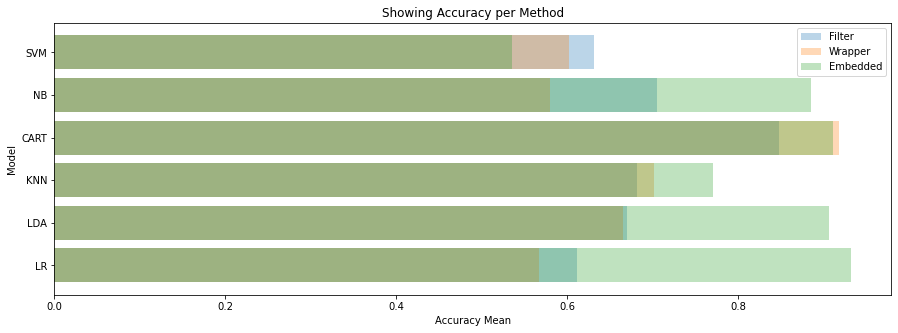

In [0]:
plt.figure(figsize=(15, 5))

plt.barh(Filter_Results['Model'], Filter_Results['Accuracy Mean'], alpha=.3, label='Filter')
plt.barh(Wrapper_Results['Model'], Wrapper_Results['Accuracy Mean'], alpha=.3, label='Wrapper')
plt.barh(Embedded_Results['Model'], Embedded_Results['Accuracy Mean'], alpha=.3, label='Embedded')
plt.legend()
plt.xlabel('Accuracy Mean')
plt.ylabel('Model')
plt.title('Showing Accuracy per Method')
plt.show()

In the bar chart above, it looks at first like Embedded method features have the highest accuracy in this senario. However, it's a bit of a red flag that most of the model methods have the highest accuracy with the Embedded features. The Embedded features may be overfitting the dataset. 

Instead, I will use the Wrapper method features because they scored the 2nd highest in accuracy mean accross all feature selection methods and model types.

# Begin Milestone02

## Model Evaluation

I had previously determined for Milestone01 that the features selected by the wrapper method to predict the target variable (diaper_df[591]) yeilded the best model results. Therefore, for Milestone02 I will be using only those features selected by the wrapper method (Wrapper_Features) in the decision tree, ensemble, and SVM models to come.

After testing each of the models: Decision Tree, Ensemble, and SVM, I noticed that the accuracy of each model was decreasing as I ran the models. I'm wondering if I did anything to make this happen and how to fix this? I'm confused on how to know when a result is real or fake.

#### Decision Tree Model

In [0]:
#defining the features, X, and the target is still Y from before
X = X_resam[Wrapper_Features] 
Y = Y_resam

In [0]:
#ensure that the decision tree is deterministic
import numpy as np
np.random.seed(101)

In [0]:
#creating my model variables
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [0]:
# Use entropy = no limit on samples for split
model_ent = DecisionTreeClassifier(criterion='entropy', random_state=1).fit(X_train, y_train) 
y_ent_pred = model_ent.predict(X_test)

# Use information gain (default) limit min_samples to 4
model_gini = DecisionTreeClassifier(min_samples_leaf=3).fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)

# NOTE: You should, when testing models, only vary 1 thing at a time. 

In [36]:
# Generate an accuracy Score
print("Entropy accuracy is : {}%".format(accuracy_score(y_test, y_ent_pred)*100))
print("Gini accuracy is : {}%".format(accuracy_score(y_test, y_gini_pred)*100))

accuracy_ent = round(np.sum(accuracy_score(y_test, y_ent_pred)*100))
accuracy_gini = round(np.sum(accuracy_score(y_test, y_gini_pred)*100))

Accuracy_DecTree = pd.DataFrame(np.array([['DecTree_entropy',accuracy_ent], 
                                ['DecTree_gini',accuracy_gini]]))

Entropy accuracy is : 91.64556962025317%
Gini accuracy is : 91.64556962025317%


In [37]:
#confusion matrix
pd.DataFrame(
    confusion_matrix(y_test, y_gini_pred),
    columns=['Predicted 1', 'Predicted -1'],
    index=['True 1', 'True -1']
)

,Predicted 1,Predicted -1
True 1,176,14
True -1,19,186


Notice how many false predictions this model returns.

#### Ensemble Model

In [38]:
nTrees = 100
max_depth = 10
min_node_size = 10
verbose = 0

clf = RandomForestClassifier(n_estimators=nTrees, max_depth=max_depth, verbose=verbose, min_samples_leaf=min_node_size)
clf.fit(X_train, y_train)
print(clf.feature_importances_)

[0.05487941 0.05357306 0.03974006 0.28519772 0.23081786 0.04299097
 0.0213586  0.2302777  0.02473168 0.01643293]


From the feature importances above, it looks like our Random Forest classifier determined that the 3rd and 5th features in Wrapper_Features are the most useful.

In [39]:
y_rforest_pred = clf.predict(X_test)
Accuracy = [1 for i in range(len(y_rforest_pred)) if y_test[i] == y_rforest_pred[i]]
Accuracy = round(float(np.sum(Accuracy))/len(y_rforest_pred)*100,2)
print("Accuracy on Testing Data = %.2f%%"%Accuracy)

Accuracy_ensemble = pd.DataFrame(np.array([['RandomForest',Accuracy]]))

Accuracy on Testing Data = 93.16%


In [40]:
#confusion matrix
pd.DataFrame(
    confusion_matrix(y_test, y_rforest_pred),
    columns=['Predicted 1', 'Predicted -1'],
    index=['True 1', 'True -1']
)

,Predicted 1,Predicted -1
True 1,185,5
True -1,22,183


#### SVM Model

In [0]:
cost = .9 # penalty parameter of the error term
gamma = 5 # defines the influence of input vectors on the margins

In [0]:
#defining X as the feature columns but zscored
X = pd.DataFrame(ss.zscore(X),columns=X.columns)

#creating my model variables
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [43]:
# Test a LinearSVC
clf1 = svm.LinearSVC(C=cost).fit(X_train, y_train)
clf1.predict(X_test)
print("LinearSVC")
print(classification_report(clf1.predict(X_test), y_test))

Accuracy_svm = []

# Test linear, rbf and poly kernels
for k in ('linear', 'rbf', 'poly'):
    clf = svm.SVC(gamma=gamma, kernel=k, C=cost).fit(X_train, y_train)
    y_svm_pred = clf.predict(X_test)
    Accuracy = [1 for i in range(len(y_svm_pred)) if y_test.iloc[i] == y_svm_pred[i]]
    Accuracy = round(float(np.sum(Accuracy))/len(y_svm_pred)*100,2)
    Accuracy_svm.append([k,Accuracy])
    print("Accuracy on Testing Data = %.2f%%"%Accuracy)    
    print(k)
    print(classification_report(clf.predict(X_test), y_test))

LinearSVC
              precision    recall  f1-score   support

          -1       0.62      0.65      0.64       193
           1       0.65      0.62      0.63       202

    accuracy                           0.64       395
   macro avg       0.64      0.64      0.64       395
weighted avg       0.64      0.64      0.64       395



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


AttributeError: ignored

Notice how the SVM models didn't do as well at all even across many kernels. However, RBF seemed to do the best.

In [0]:
Accuracy_svm = pd.DataFrame(np.array([['SVM_linear', 71.03], ['SVM_rbf', 81.61], ['SVM_poly', 76.83]]))

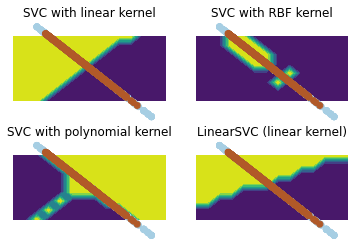

In [45]:
# To make plotting easier, let's just use two features.
X = X.iloc[:, :2]

h = .5  # step size in the mesh
#cost = .9  # update the cost
#gamma = 10 # update the gamma 

# testing other kernels on unscaled data (for plotting tht support vectors)
svc = svm.SVC(kernel='linear', C=cost).fit(X, Y)
rbf_svc = svm.SVC(kernel='rbf', gamma=gamma, C=cost).fit(X, Y)
poly_svc = svm.SVC(kernel='poly', gamma=gamma, degree=3, C=cost).fit(X, Y)
lin_svc = svm.LinearSVC(C=cost).fit(X, Y)

# create a mesh to plot in
x_min, x_max = X.iloc[:,0].min() - 1, X.iloc[:,0].max() + 1
y_min, y_max = Y.min() - 1, Y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial kernel',
          'LinearSVC (linear kernel)']

for i, kernel in enumerate((svc, rbf_svc, poly_svc, lin_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    Z = kernel.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z)
    plt.axis('off')
    
    # Plot also the training points
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=Y, cmap=plt.cm.Paired)
    plt.title(titles[i])

plt.show()

What a weird shape! 

In [46]:
#Final model comparison in terms of Accuracy
Accuracy_df = pd.concat([Accuracy_DecTree,Accuracy_ensemble,Accuracy_svm])
Accuracy_df.columns=['Model','Accuracy']
Accuracy_df.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
0,RandomForest,93.16
0,DecTree_entropy,92.0
1,DecTree_gini,92.0
1,SVM_rbf,81.61
2,SVM_poly,76.83
0,SVM_linear,71.03


Text(0.5, 1.0, 'Showing Accuracy per Method')

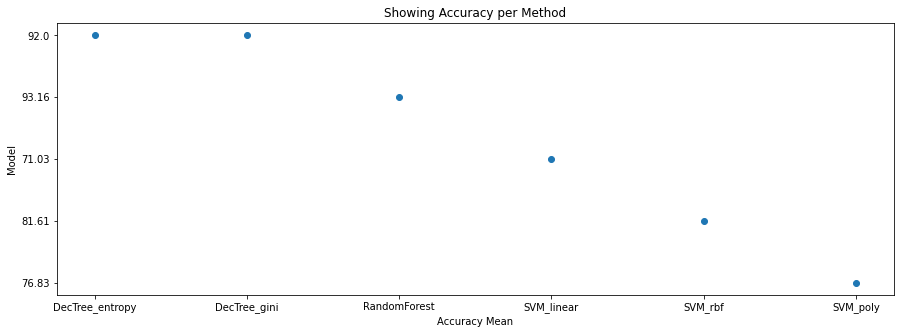

In [47]:
ax = plt.figure(figsize=(15, 5)).gca()

ax.scatter(Accuracy_df['Model'], Accuracy_df['Accuracy'])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Accuracy Mean')
ax.set_ylabel('Model')
ax.set_title('Showing Accuracy per Method')

# Begin Milestone03

## simple NN model

In [48]:
X_resam.shape, Y_resam.shape

((1972, 589), (1972,))

In [0]:
#defining the features, X, and the target is still Y from before
X = X_resam[Wrapper_Features] 
Y = Y_resam

#ensure that the decision tree is deterministic
import numpy as np
np.random.seed(101)

#creating my model variables
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [0]:
# Creating a numerically stable logistic s-shaped definition to call
def sigmoid(x):
    x = np.clip(x, -500, 500)
    if x.any()>=0:
        return 1/(1 + np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))
   

# define the dimentions and set the weights to random numbers
def init_parameters(dim1, dim2=1,std=1e-1, random = True):
    if(random):
        return(np.random.random([dim1,dim2])*std)
    else:
        return(np.zeros([dim1,dim2]))
   

# Single layer network: Forward Prop
# Passed in the weight vectors, bias vector, the input vector and the Y
def fwd_prop(W1,bias,X,Y):

    Z1 = np.dot(W1,X) + bias # dot product of the weights and X + bias
    A1 = sigmoid(Z1)  # Uses sigmoid to create a predicted vector

    return(A1)


#Single layer network: Backprop
def back_prop(A1,W1,bias,X,Y):

    m = X.shape[1] # used the calculate the cost by the number of inputs -1/m
   
    # Cross entropy loss function
    cost = (-1/m)*np.sum(Y*np.log(A1) + (1-Y)*np.log(1-A1)) # cost of error
    dZ1 = A1 - Y                                            # subtract actual from pred weights
    dW1 = (1/m) * np.dot(dZ1, X.T)                          # calc new weight vector
    dBias = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)  # calc new bias vector
    
    grads ={"dW1": dW1, "dB1":dBias} # Weight and bias vectors after backprop
    
    return(grads,cost)


def run_grad_desc(num_epochs,learning_rate,X,Y,n_1):
    
    n_0, m = X.shape
    
    W1 = init_parameters(n_1, n_0, True)
    B1 = init_parameters(n_1,1, True)
    
    loss_array = np.ones([num_epochs])*np.nan # resets the loss_array to NaNs
    
    for i in np.arange(num_epochs):
        A1 = fwd_prop(W1,B1,X,Y)                # get predicted vector
        grads,cost = back_prop(A1,W1,B1,X,Y)    # get gradient and the cost from BP 
        
        W1 = W1 - learning_rate*grads["dW1"]    # update weight vector LR*gradient*[BP weights]
        B1 = B1 - learning_rate*grads["dB1"]    # update bias LR*gradient[BP bias]
        
        loss_array[i] = cost                    # loss array gets cross ent values
        
        parameter = {"W1":W1,"B1":B1}           # assign 
    
    return(parameter,loss_array)

## DNN model

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.datasets import imdb
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.regularizers import l2

In [0]:
# fix random seed for reproducibility
np.random.seed(7)

In [174]:
# Create the model using keras Sequential api

x_test = X_test.to_numpy()
x_train = X_train.to_numpy()

model = Sequential()
model.add(Dense(100, input_dim=10, activation='tanh', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3, noise_shape=None , seed=None))

model.add(Dense(100, activation='tanh', kernel_regularizer=l2(0.1)))
model.add(Dropout(0.3, noise_shape=None , seed=None))

model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 100)               1100      
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 101       
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________
None


In [175]:
x_test.shape, y_test.sh

((395, 10), (395,))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [177]:
model_output = model.fit(x_train, y_train, epochs=100, batch_size=25, verbose=1, validation_data=(x_test, y_test))

Train on 1577 samples, validate on 395 samples
Epoch 1/100
1577/1577 [==============================] - 0s 198us/step - loss: 8.4963 - accuracy: 0.4724 - val_loss: 5.3125 - val_accuracy: 0.5063
Epoch 2/100
1577/1577 [==============================] - 0s 86us/step - loss: 3.4945 - accuracy: 0.4819 - val_loss: 2.1697 - val_accuracy: 0.0000e+00
Epoch 3/100
1577/1577 [==============================] - 0s 82us/step - loss: 1.6724 - accuracy: 0.4889 - val_loss: 1.0537 - val_accuracy: 0.0000e+00
Epoch 4/100
1577/1577 [==============================] - 0s 88us/step - loss: 1.0491 - accuracy: 0.5130 - val_loss: 0.8359 - val_accuracy: 0.0000e+00
Epoch 5/100
1577/1577 [==============================] - 0s 82us/step - loss: 0.8329 - accuracy: 0.4775 - val_loss: 0.6655 - val_accuracy: 0.0000e+00
Epoch 6/100
1577/1577 [==============================] - 0s 88us/step - loss: 0.7598 - accuracy: 0.4788 - val_loss: 0.7378 - val_accuracy: 0.5063
Epoch 7/100
1577/1577 [==============================] - 0s 

In [178]:
print('Training Accuracy: ',np.mean(model_output.history['accuracy']))
print('Validation Accuracy: ',np.mean(model_output.history['val_accuracy']))

Training Accuracy:  0.49535203
Validation Accuracy:  0.20759493887424468


In [179]:
y_pred = model.predict(x_test)
rounded = [round(x[0]) for x in y_pred]
y_pred1 = np.array(rounded, dtype='int64')

average_precision_score(y_test, y_pred1)

0.5063291139240507